## Wykrywanie naczyń dna siatkówki oka

__Autorzy:__
 - Kacper Magnuszewski 151746, kacper.magnuszewski@student.put.poznan.pl
 - Tymoteusz Jagła 151811, tymoteusz.jagla@student.put.poznan.pl 

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mplt
import skimage.exposure as exp
import skimage.filters as filter

mplt.rcParams['figure.figsize'] = [20, 12]

In [2]:
IMAGE = "images/01_h.jpg"
IMAGE_PATHS = ["images/01_h.jpg",  "images/02_h.jpg",  "images/03_h.jpg",  "images/04_h.jpg",  "images/05_h.jpg"]
LABELED = "manual/01_h.tif"
LABELED_PATHS = ["manual/01_h.tif",  "manual/02_h.tif",  "manual/03_h.tif",  "manual/04_h.tif",  "manual/05_h.tif"]
FOV = "fovmasks/01_h_mask.tif"
FOV_PATHS = ["fovmasks/01_h_mask.tif",  "fovmasks/02_h_mask.tif",  "fovmasks/03_h_mask.tif",  "fovmasks/04_h_mask.tif",  "fovmasks/05_h_mask.tif"]


class Image:
    def __init__(self, image, gammaCorrected, labeled, fov):
        self.image = image
        self.gammaCorrected = gammaCorrected
        self.labeled = labeled
        self.fov = fov


def read_single_image(imagePath, labeledPath, fovPath):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_gamma_corrected = exp.adjust_gamma(image, 1.1)
    image_labeled = cv2.imread(labeledPath, cv2.IMREAD_GRAYSCALE)
    image_labeled[np.where(image_labeled > 0)] = 1
    image_fov = cv2.imread(fovPath, cv2.IMREAD_GRAYSCALE)

    return Image(image, image_gamma_corrected, image_labeled, image_fov)


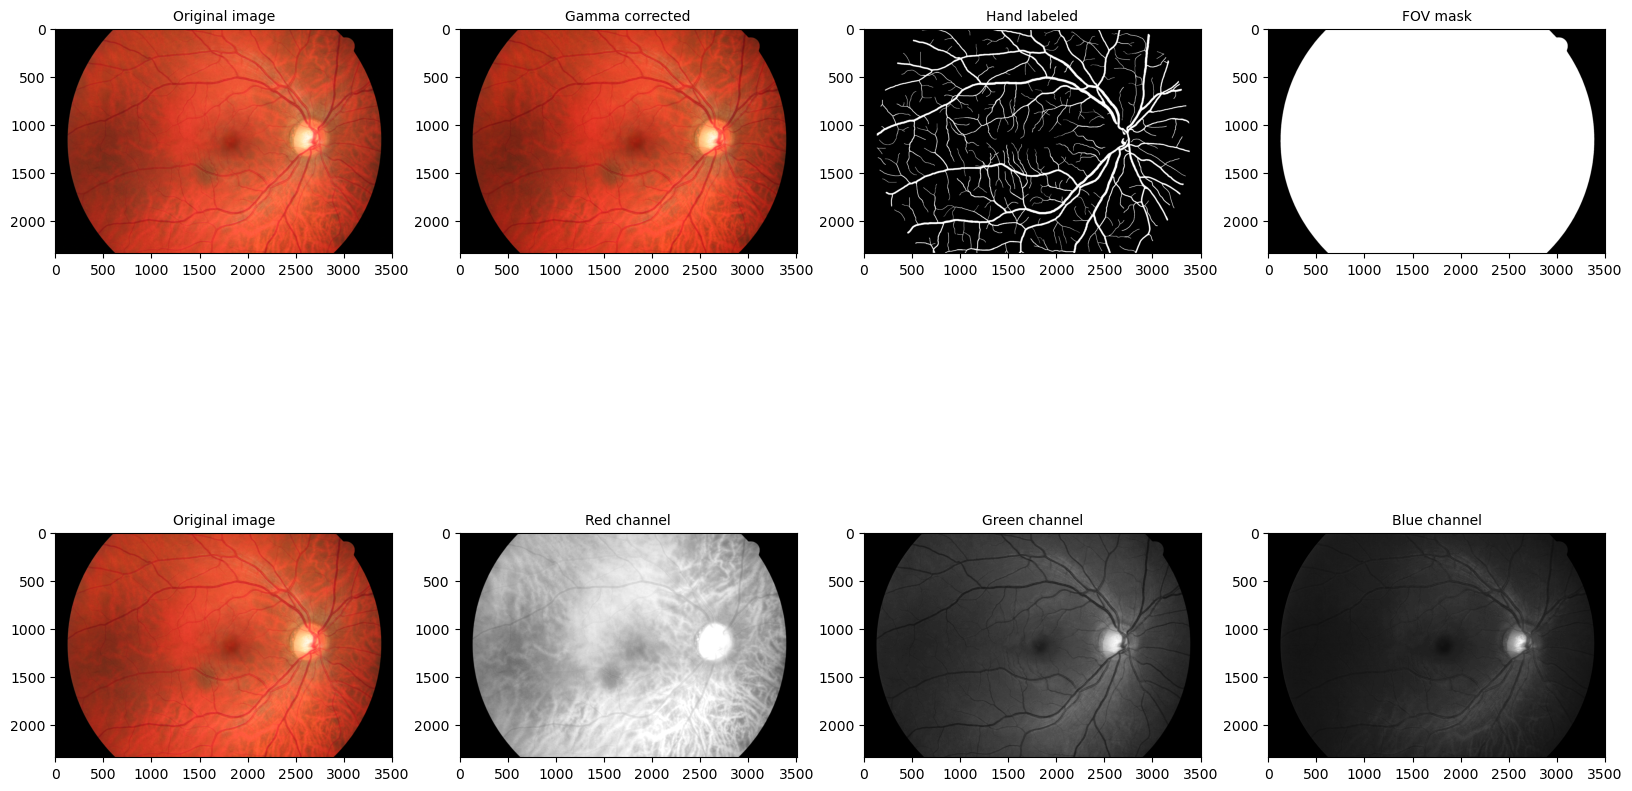

In [3]:
# images = read_images("images/", "manual/", "fovmasks/")
images = []

for image_path, labeled_path, fov_path in zip(IMAGE_PATHS, LABELED_PATHS, FOV_PATHS):
    images.append(read_single_image(image_path, labeled_path, fov_path))

image = cv2.imread(IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gamma_corrected = exp.adjust_gamma(image, 1.1)
image_labeled = cv2.imread(LABELED, cv2.IMREAD_GRAYSCALE)
image_labeled[np.where(image_labeled > 0)] = 1
image_fov = cv2.imread(FOV, cv2.IMREAD_GRAYSCALE)

image_red = image_gamma_corrected[:, :, 0]
image_green = image_gamma_corrected[:, :, 1]
image_blue = image_gamma_corrected[:, :, 2]

fig, ax = plt.subplots(2, 4)
# plt.figure(figsize = (20, 15))
ax[0][0].set_title("Original image", fontdict = {'fontsize': 10})
ax[0][1].set_title("Gamma corrected", fontdict = {'fontsize': 10})
ax[0][2].set_title("Hand labeled", fontdict = {'fontsize': 10})
ax[0][3].set_title("FOV mask", fontdict = {'fontsize': 10})
ax[0][0].imshow(image)
ax[0][1].imshow(image_gamma_corrected)
ax[0][2].imshow(image_labeled, cmap = "gray")
ax[0][3].imshow(image_fov, cmap = "gray")

ax[1][0].set_title("Original image", fontdict = {'fontsize': 10})
ax[1][1].set_title("Red channel", fontdict = {'fontsize': 10})
ax[1][2].set_title("Green channel", fontdict = {'fontsize': 10})
ax[1][3].set_title("Blue channel", fontdict = {'fontsize': 10})
ax[1][0].imshow(image)
ax[1][1].imshow(image_red, cmap = "gray")
ax[1][2].imshow(image_green, cmap = "gray")
ax[1][3].imshow(image_blue, cmap = "gray")

In [4]:
def filterImage(image):
    filtered = filter.sato(image)

    min_val = np.min(filtered)
    max_val = np.max(filtered)
    filtered = (filtered - min_val) / (max_val - min_val)

    return filtered


def equalize(image):
    equalized = exp.equalize_adapthist(image)
    
    return equalized


def generateMask(image, fov):
    generated_mask = np.zeros(image.shape)
    generated_mask[np.where(image > filter.threshold_local(image, block_size = 3, method = 'mean'))] = 1
    generated_mask[np.where(image < filter.threshold_mean(image) * 3)] = 0
    generated_mask[np.where(fov == 0 )] = 0

    return generated_mask

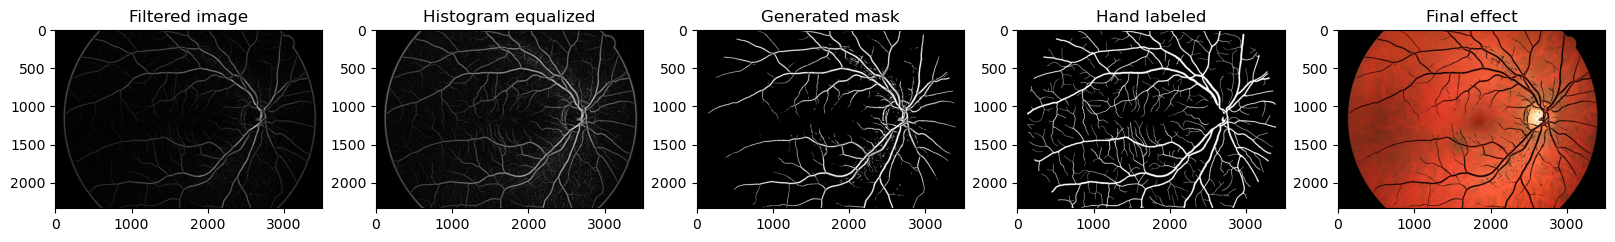

In [5]:
filtered = filterImage(image_green)
plt.subplot(151)
plt.title("Filtered image")
plt.imshow(filtered, cmap="gray");

equalized = equalize(filtered)
plt.subplot(152)
plt.title("Histogram equalized")
plt.imshow(equalized, cmap="gray")

generated_mask = generateMask(equalized, image_fov)
plt.subplot(153)
plt.title("Generated mask")
plt.imshow(generated_mask, cmap="gray");

plt.subplot(154)
plt.title("Hand labeled")
plt.imshow(image_labeled, cmap = "gray")

image_final = image
image_final[np.where(generated_mask == 1)] = 0
plt.subplot(155)
plt.title("Final effect")
plt.imshow(image_final)

In [7]:
fig, axs = plt.subplots(len(images), 3)
generated_masks = []

for image in images:
    generated_masks.append((generateMask(equalize(filterImage(image.image[:, :, 1])), image.fov), image.labeled, image.fov))

for i, maskTuple in enumerate(generated_masks):
    mask, labeled, fov = maskTuple
    confusion_matrix = np.zeros(mask.shape)

    confusion_matrix[np.where(mask != labeled)] = 1

    true_positive = np.sum(labeled[np.where(mask == 1)] == 1)
    true_negative = np.sum(labeled[np.where(mask == 0)] == 0)
    false_positive = np.sum(labeled[np.where(mask == 1)] == 0)
    false_negative = np.sum(labeled[np.where(mask == 0)] == 1)

    accuracy = round((true_positive + true_negative) / (true_positive + false_positive + false_negative + true_negative), 2)
    sensitivity = round(true_positive / (true_positive + false_negative + 1), 2)
    specificity = round(true_negative / (false_positive + true_negative + 1), 2)
    precision = round(true_positive / (true_positive + false_positive + 1), 2)
    
    print('TP:', true_positive)
    print('FP:', false_positive)
    print('FN:', false_negative)
    print('TN:', true_negative)
    print("\n")
    print("Accuracy: ", accuracy)
    print("Sensitivity: ", sensitivity)
    print("Specificity: ", specificity)
    print("Precision: ", precision)
    print("\n\n")

    axs[i][0].set_title("Generated mask")
    axs[i][0].imshow(mask, cmap = "gray")

    axs[i][1].set_title("Hand labeled")
    axs[i][1].imshow(labeled, cmap = "gray")

    axs[i][2].set_title("Error matrix")
    axs[i][2].imshow(confusion_matrix)


plt.show()

TP: 438187
FP: 8
FN: 71
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 15
FN: 135
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 22
FN: 196
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 29
FN: 266
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 38
FN: 332
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 46
FN: 402
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 52
FN: 478
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 62
FN: 551
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
FP: 70
FN: 627
TN: 7396142


Accuracy:  1.0
Sensitivity:  1.0
Specificity:  1.0
Precision:  1.0



TP: 438187
F

: 